# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

/content/drive/MyDrive/Gproject/MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)
dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)

positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [4]:
from src.Data import *
from src.Preprocessing import *
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 20

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [5]:
model_name = 'mlp_window(protein_augmented)'

x_cts   = variables.x_cts_window
x_cat   = variables.x_cat_window
y_label = variables.y_label

print(f"{len(x_cts)} x_cts: {x_cts}")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

2 x_cts: ['Proline', 'flexibility']
12 x_cat: ['SEQ', 'nS/nT', 'nAli', 'nPos', 'phi_psi', 'SS', 'side_-1', 'side_1', 'side_2', 'side_3', 'side_4', 'side_5']
1 y_label: ['positivity']
dummy x shape: (8910, 80)
dummy y shape: (8910, 1)


{0: 'Proline',
 1: 'flexibility',
 2: 'SEQ_S',
 3: 'SEQ_T',
 4: 'nS/nT_1',
 5: 'nS/nT_2',
 6: 'nS/nT_3',
 7: 'nS/nT_4',
 8: 'nS/nT_5',
 9: 'nS/nT_6',
 10: 'nS/nT_7',
 11: 'nS/nT_8',
 12: 'nS/nT_9',
 13: 'nS/nT_10',
 14: 'nS/nT_11',
 15: 'nS/nT_12',
 16: 'nS/nT_13',
 17: 'nS/nT_14',
 18: 'nS/nT_15',
 19: 'nAli_0',
 20: 'nAli_1',
 21: 'nAli_2',
 22: 'nAli_3',
 23: 'nPos_0',
 24: 'nPos_1',
 25: 'nPos_2',
 26: 'nPos_3',
 27: 'phi_psi_alpha',
 28: 'phi_psi_beta',
 29: 'phi_psi_other',
 30: 'SS_C',
 31: 'SS_E',
 32: 'SS_H',
 33: 'side_-1_cycle',
 34: 'side_-1_gly',
 35: 'side_-1_long',
 36: 'side_-1_normal',
 37: 'side_-1_pro',
 38: 'side_-1_small',
 39: 'side_-1_very_small',
 40: 'side_1_None',
 41: 'side_1_cycle',
 42: 'side_1_gly',
 43: 'side_1_long',
 44: 'side_1_normal',
 45: 'side_1_pro',
 46: 'side_1_small',
 47: 'side_1_very_small',
 48: 'side_2_None',
 49: 'side_2_cycle',
 50: 'side_2_gly',
 51: 'side_2_long',
 52: 'side_2_normal',
 53: 'side_2_pro',
 54: 'side_2_small',
 55: 'side_

## cross validation

In [6]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = MLP(x_dim, y_dim)
        model.build(n_layers, n_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_data=[test_x, test_y], save_path=save_path, verbose=2)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0099778270509978
up-sampled train dataset: (13960, 80) (13960, 1)
Epoch 1/10000
437/437 - 3s - loss: 0.6159 - accuracy: 0.6607 - val_loss: 0.5717 - val_accuracy: 0.6942 - 3s/epoch - 6ms/step
Epoch 2/10000
437/437 - 1s - loss: 0.5998 - accuracy: 0.6709 - val_loss: 0.5964 - val_accuracy: 0.6689 - 1s/epoch - 3ms/step
Epoch 3/10000
437/437 - 2s - loss: 0.5974 - accuracy: 0.6683 - val_loss: 0.5547 - val_accuracy: 0.7054 - 2s/epoch - 3ms/step
Epoch 4/10000
437/437 - 1s - loss: 0.5936 - accuracy: 0.6733 - val_loss: 0.5309 - val_accuracy: 0.7194 - 1s/epoch - 3ms/step
Epoch 5/10000
437/437 - 1s - loss: 0.5933 - accuracy: 0.6718 - val_loss: 0.6619 - val_accuracy: 0.6190 - 1s/epoch - 3ms/step
Epoch 6/10000
437/437 - 1s - loss: 0.5918 - accuracy: 0.6743 - val_loss: 0.6109 - val_accuracy: 0.6543 - 1s/epoch - 3ms/step
Epoch 7/10000
437/437 - 3s -

,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,8,1.156,0.589783,0.526780,0.526780,72.95,4.12,54.05,7.66
1,5,100,9,1.155,0.575559,0.520597,0.520597,72.73,3.71,48.65,6.90
2,5,100,28,1.699,0.571828,0.506102,0.506102,74.69,4.00,48.65,7.39
3,5,100,8,1.202,0.573036,0.516145,0.516145,74.19,3.72,45.95,6.88
4,5,100,5,1.059,0.584173,0.519575,0.519575,74.58,3.36,40.54,6.21
5,5,100,2,1.022,0.578031,0.465838,0.465838,78.11,3.43,35.14,6.25
6,5,100,0,0.996,0.605301,0.526135,0.526135,73.63,4.23,54.05,7.84
7,5,100,4,1.045,0.566190,0.441047,0.441047,79.91,2.93,27.03,5.29
8,5,100,9,1.273,0.582441,0.497930,0.497930,75.42,3.91,45.95,7.20
9,5,100,9,1.232,0.575196,0.523998,0.523998,72.17,3.45,45.95,6.42



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0099778270509978
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_1of20.h5


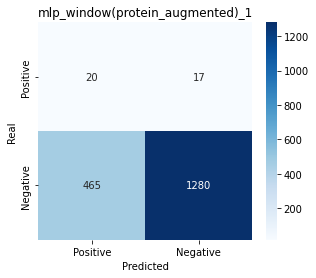

accuracy  : 72.95
precision : [98.69  4.12]
recall    : [73.35 54.05]
f1_score  : [84.16  7.66]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0099778270509978
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_2of20.h5


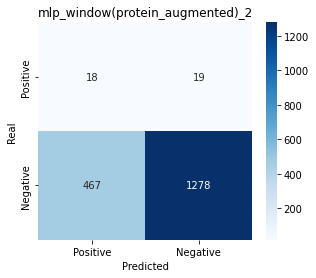

accuracy  : 72.72999999999999
precision : [98.54  3.71]
recall    : [73.24 48.65]
f1_score  : [84.02  6.9 ]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_3of20.h5


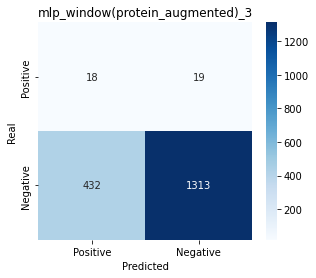

accuracy  : 74.69
precision : [98.57  4.  ]
recall    : [75.24 48.65]
f1_score  : [85.34  7.39]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.032036613272311214 1.0102974828375288
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_4of20.h5


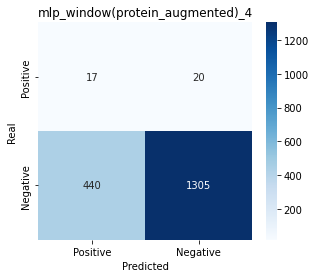

accuracy  : 74.19
precision : [98.49  3.72]
recall    : [74.79 45.95]
f1_score  : [85.02  6.88]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.037974683544303806 1.0103567318757194
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_5of20.h5


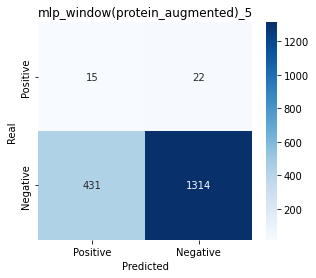

accuracy  : 74.58
precision : [98.35  3.36]
recall    : [75.3  40.54]
f1_score  : [85.3   6.21]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_6of20.h5


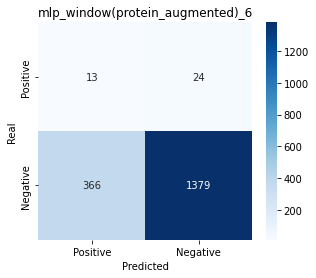

accuracy  : 78.11
precision : [98.29  3.43]
recall    : [79.03 35.14]
f1_score  : [87.61  6.25]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_7of20.h5


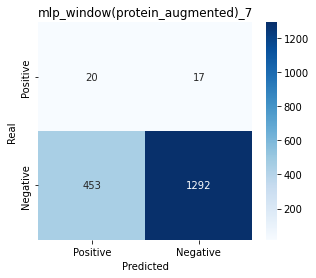

accuracy  : 73.63
precision : [98.7   4.23]
recall    : [74.04 54.05]
f1_score  : [84.61  7.84]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_8of20.h5


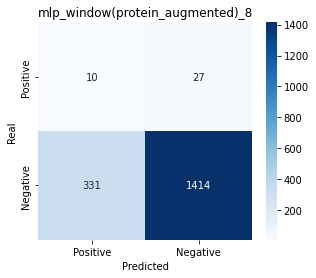

accuracy  : 79.91
precision : [98.13  2.93]
recall    : [81.03 27.03]
f1_score  : [88.76  5.29]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_9of20.h5


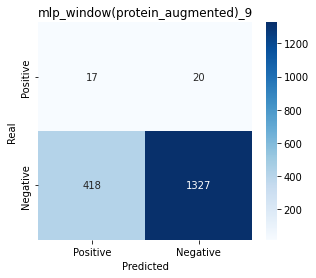

accuracy  : 75.42
precision : [98.52  3.91]
recall    : [76.05 45.95]
f1_score  : [85.83  7.2 ]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_10of20.h5


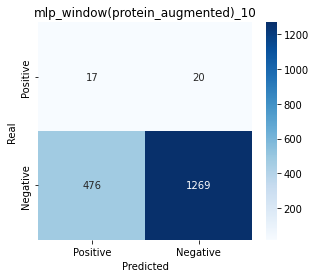

accuracy  : 72.17
precision : [98.45  3.45]
recall    : [72.72 45.95]
f1_score  : [83.65  6.42]

11th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_11of20.h5


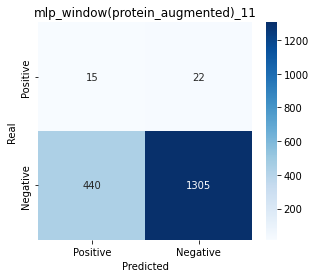

accuracy  : 74.07000000000001
precision : [98.34  3.3 ]
recall    : [74.79 40.54]
f1_score  : [84.96  6.1 ]

12th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_12of20.h5


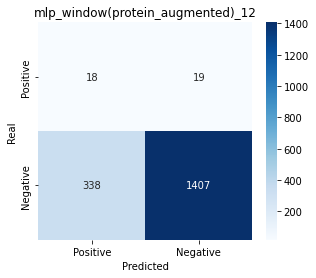

accuracy  : 79.97
precision : [98.67  5.06]
recall    : [80.63 48.65]
f1_score  : [88.74  9.16]

13th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0167410714285714
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_13of20.h5


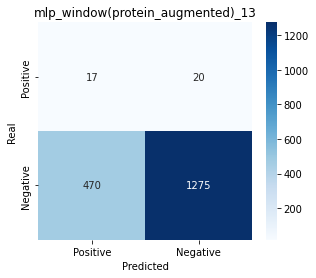

accuracy  : 72.5
precision : [98.46  3.49]
recall    : [73.07 45.95]
f1_score  : [83.88  6.49]

14th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_14of20.h5


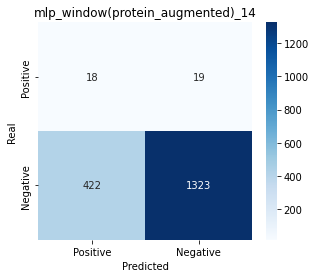

accuracy  : 75.25
precision : [98.58  4.09]
recall    : [75.82 48.65]
f1_score  : [85.71  7.55]

15th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_15of20.h5


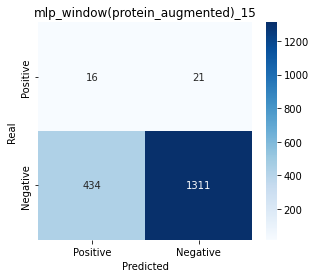

accuracy  : 74.47
precision : [98.42  3.56]
recall    : [75.13 43.24]
f1_score  : [85.21  6.57]

16th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_16of20.h5


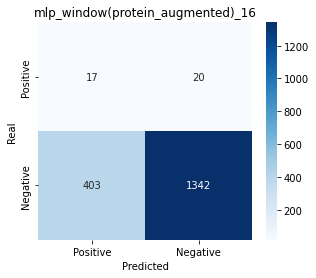

accuracy  : 76.25999999999999
precision : [98.53  4.05]
recall    : [76.91 45.95]
f1_score  : [86.39  7.44]

17th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_17of20.h5


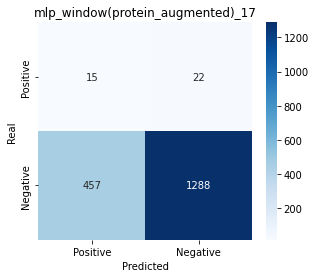

accuracy  : 73.11999999999999
precision : [98.32  3.18]
recall    : [73.81 40.54]
f1_score  : [84.32  5.89]

18th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.032036613272311214 1.0102974828375288
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_18of20.h5


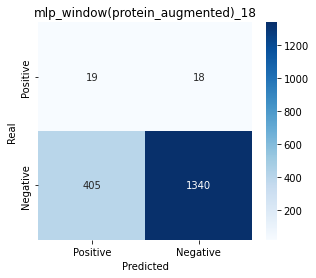

accuracy  : 76.25999999999999
precision : [98.67  4.48]
recall    : [76.79 51.35]
f1_score  : [86.37  8.24]

19th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_19of20.h5


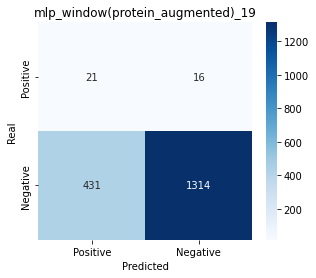

accuracy  : 74.92
precision : [98.8   4.65]
recall    : [75.3  56.76]
f1_score  : [85.46  8.59]

20th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/mlp_window(protein_augmented)_5_100_cv_20of20.h5


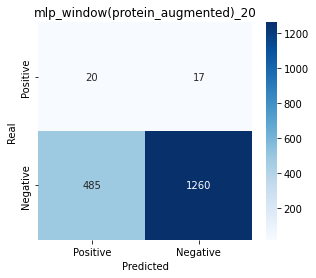

accuracy  : 71.83
precision : [98.67  3.96]
recall    : [72.21 54.05]
f1_score  : [83.39  7.38]


In [7]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = MLP(x_dim, y_dim)
    model.build(n_layers, n_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])